In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
import pydotplus
from six import StringIO
import numpy as np
import graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import time
import re

# Load the dataset
dataset = "../Dataset/cleaned_student_performance.csv"
student_performance = pd.read_csv(dataset)

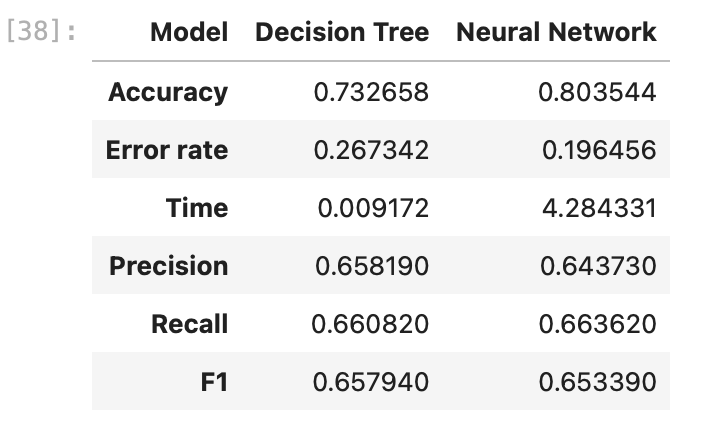

In [35]:
# In the previous phase we changed the following 

# We modified the grouping in the 'Performance Index' column and assigned labels to each group to make it easier
# to handle in model operations. ['very low (0)', 'low (1)', 'good (2)', 'high (3)', 'very high (4)']

# We removed grouping from the 'Previous Scores' column because it was causing a decrease in accuracy.
# Here is a screenshot of model results with grouped 'Previous Scores'
Image(filename='./screenshots/Grouping_Previous_Scores.png')


In [36]:
# Define features and target variable
features = ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']
target = ['Performance Index']
X = student_performance[features]
y = student_performance[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [37]:
def run_model (model, X_train, y_train, X_test, y_test, verbose=True):
    # Record the start time
    tO = time.time()
    
    # Train the model on the training data
    if verbose == False:
        model.fit(X_train, y_train.values.ravel(), verbose=0) 
    else:
        model.fit(X_train, y_train.values.ravel())
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and error rate
    accuracy = accuracy_score(y_test, y_pred)
    error_rate = 1- accuracy

    # Calculate the time taken for training and prediction
    time_taken = time.time()-tO

    # Print the accuracy, error rate, and time taken
    print("Accuracy = {}".format (accuracy))
    print("Error rate = {}".format(error_rate))
    print("Time taken = {}".format (time_taken))

    # Generate a classification report
    report = classification_report(y_test, y_pred, digits=5)
    
    # Extract macro average precision, recall, and F1-score using regular expressions
    macro_avg_values = re.findall(r"macro avg\s+([\d\.]+)\s+([\d\.]+)\s+([\d\.]+)", report)
    
    if macro_avg_values:
        precision, recall, f1 = map(float, macro_avg_values[0])
    else:
        precision, recall, f1 = None, None, None
        
    # Print the classification report
    print(report)
    
    # Calculate and print the confusion matrix
    Confusion_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix =\n {}".format(Confusion_matrix))

    # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
    TP = np.diag(Confusion_matrix)
    FP = np.sum(Confusion_matrix, axis=0) - TP
    FN = np.sum(Confusion_matrix, axis=1) - TP
    TN = np.sum(Confusion_matrix) - (TP + FP + FN)
    
    # Print TP, FP, TN, and FN
    print("TP = {}".format(TP))
    print("FP = {}".format(FP))
    print("TN = {}".format(TN))
    print("FN = {}".format(FN))
    Specificity = TN /(TN+FP)
    
    # Calculate and print Specificity
    print("Specificity = {}".format(Specificity))
    
    # Visualize confusion matrix using heat-map
    dis = ConfusionMatrixDisplay(Confusion_matrix).plot(cmap=plt.cm.RdPu)
    
    # Visualize ROC curve
    # Calculate ROC and AUC for each class
    n_classes = len(np.unique(y_test))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        y_true_one_vs_rest = (y_test == i)
        y_score = model.predict_proba(X_test)[:, i]
        fpr[i], tpr[i], _ = roc_curve(y_true_one_vs_rest, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Plot all ROC curves in one diagram
    plt.figure()
    lw = 2
    colors = ['darkorange', 'navy', 'cornflowerblue', 'red', 'purple'] 
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=lw, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for Class {i}')
    # plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Return the trained model and various evaluation metrics
    return model, accuracy, error_rate, time_taken, precision, recall, f1

Accuracy = 0.8739240506329113
Error rate = 0.12607594936708866
Time taken = 0.009922027587890625
              precision    recall  f1-score   support

           0    0.70370   0.74510   0.72381        51
           1    0.88720   0.87393   0.88052       468
           2    0.85938   0.87859   0.86888       626
           3    0.89198   0.88331   0.88762       617
           4    0.88038   0.86385   0.87204       213

    accuracy                        0.87392      1975
   macro avg    0.84453   0.84896   0.84657      1975
weighted avg    0.87440   0.87392   0.87409      1975

Confusion Matrix =
 [[ 38  13   0   0   0]
 [ 16 409  43   0   0]
 [  0  39 550  37   0]
 [  0   0  47 545  25]
 [  0   0   0  29 184]]
TP = [ 38 409 550 545 184]
FP = [16 52 90 66 25]
TN = [1908 1455 1259 1292 1737]
FN = [13 59 76 72 29]
Specificity = [0.99168399 0.96549436 0.93328391 0.95139912 0.98581158]


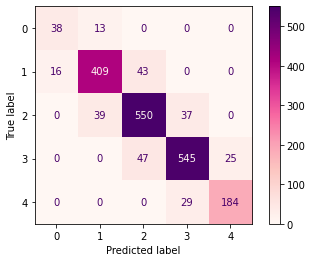

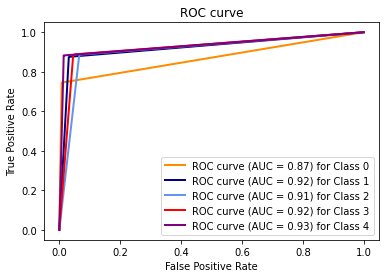

In [38]:
# Initialize decision tree model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
# Train the decision tree model using the 'run_model' function
# This function will return the trained model and various evaluation metrics
decision_tree, decision_tree_accuracy, decision_tree_error_rate, decision_tree_time, decision_tree_precision, decision_tree_recall, decision_tree_f1 = run_model(decision_tree, X_train, y_train, X_test, y_test)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.323213 to fit


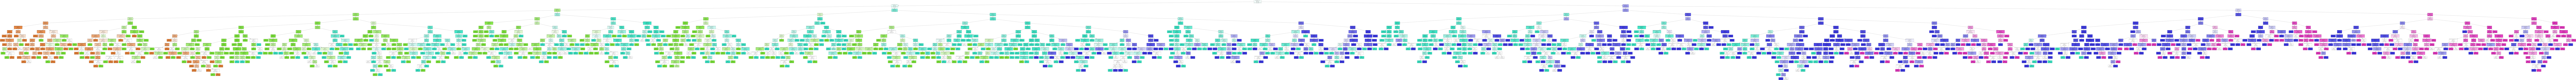

In [39]:
# Visualize the Decision Tree
# Export the decision tree to DOT format
dot_data = export_graphviz(decision_tree, out_file=None, feature_names=features, class_names=['very low (0)', 'low (1)', 'good (2)','high (3)','very high (4)'], filled=True)

# Visualize the decision tree using Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # This will save the visualization as "decision_tree.pdf"
graph.view("decision_tree")    # This will open the PDF file for viewing
Image(graph.pipe(format='png')) # A higher quality decision tree can be found in “Supervised learning” folder


In [ ]:
# neural network model
# Create a StandardScaler object to standardize the features
scaler = StandardScaler()
# Standardize the features in the training data (X_train)
X_train = scaler. fit_transform(X_train)
# Standardize the features in the testing data (X_test)
X_test = scaler.fit_transform(X_test)

# Define parameters for the neural network model
params_nn = {
    'hidden_layer_sizes': (30, 30, 30), # Specify the architecture of the neural network
    'activation': 'logistic', # Use the logistic (sigmoid) activation function
    'solver': 'adam'  # Use the 'adam' solver for optimization
}

# Create an MLPClassifier (Multi-Layer Perceptron) model with the specified parameters
neural_network = MLPClassifier(**params_nn)

# Train the neural network model using the 'run_model' function
# This function will return the trained model and various evaluation metrics
neural_network, neural_network_accuracy, neural_network_error_rate, neural_network_time, neural_network_precision, neural_network_recall, neural_network_f1  = run_model(neural_network, X_train, y_train, X_test, y_test)

In [ ]:
# Table Comparison
# Define model-specific data as dictionaries
models_data = [
    {
        "Model": "Decision Tree",
        "Accuracy": decision_tree_accuracy,
        "Error rate": decision_tree_error_rate,
        "Time": decision_tree_time,
        "Precision": decision_tree_precision,
        "Recall": decision_tree_recall,
        "F1": decision_tree_f1
    },
    {
        "Model": "Neural Network",
        "Accuracy": neural_network_accuracy,
        "Error rate": neural_network_error_rate,
        "Time": neural_network_time,
        "Precision": neural_network_precision,
        "Recall": neural_network_recall,
        "F1": neural_network_f1
    }
]

# Create a DataFrame from the list of dictionaries
comparison_table = pd.DataFrame(models_data)
# Set the "Model" column as the index
comparison_table.set_index("Model", inplace=True)
comparison_table = comparison_table.T

# Display the comparison table
comparison_table

In [ ]:
# Pie Charts Comparison
# Get the index (attributes) from the 'comparison_table'
attributes = comparison_table.index
# Define a list of colors for the pie charts
colors = ["purple", "lightcoral"]
# Iterate over each attribute in the 'attributes' list
for attribute in attributes:
    # Select data for the current attribute from the 'comparison_table'
    data = comparison_table.loc[attribute]
    # Normalize the data by dividing each value by the sum of all values
    normalized_data = data / data.sum()
    # Extract the labels from the normalized data
    labels = normalized_data.index
    # Create a pie chart using the normalized data
    plt.pie(normalized_data, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    # Set the aspect ratio of the pie chart to be equal, creating a circle
    plt.axis('equal')
    # Set the title of the pie chart based on the current attribute
    plt.title(attribute)
    # Display the pie chart
    plt.show()

In [ ]:
# Bar Chart Comparison
# Define a list of colors for the bar chart
colors = ["purple", "lightcoral"]
# Create a bar chart
comparison_table.plot(kind='bar', figsize=(10, 6), color=colors)

# Set the title and labels
plt.title("Bar chart comparison")
plt.xlabel("Metrics")
plt.ylabel("Values")

# Show the legend
plt.legend(title="Model")

# Show the plot
plt.show()

In [ ]:
# The Neural Network is a better choice since it has higher accuracy, F1 score, precision, and recall, along with a lower error rate. 
# While the Decision Tree is significantly faster, the higher performance of the Neural Network makes it the better option.